In [1]:
import h5py
import numpy as np
import pandas as pd

In [2]:
out_dir = "TEST"
file_name = "OUT.h5"
num_procs = 2

In [3]:
hf = h5py.File("TEST/job0/OUT.h5", "r")

for key in hf:
    print(key, hf[key].shape)


SCD_h1_m0_t0 (10,)
SCD_h1_m0_t1 (10,)
SCD_h1_m0_t2 (10,)
SCD_h1_m0_t3 (10,)
SCD_h1_m0_t4 (10,)
SCD_h1_m0_t5 (10,)
background_index (10,)
chrom (10,)
diffSCD_h1_m0_t0 (10,)
diffSCD_h1_m0_t1 (10,)
diffSCD_h1_m0_t2 (10,)
diffSCD_h1_m0_t3 (10,)
diffSCD_h1_m0_t4 (10,)
diffSCD_h1_m0_t5 (10,)
end (10,)
experiment_id (10,)
flank_bp (10,)
genomic_SCD (10,)
map_h1_m0 (10, 512, 512, 6)
orientation (10,)
refmap_h1_m0 (1, 512, 512, 6)
spacer_bp (10,)
start (10,)
strand (10,)


In [4]:
def collect_h5(file_name, out_dir, num_procs):
    # count variants
    num_variants = 0
    for pi in range(num_procs):
        # open job
        job_h5_file = "%s/job%d/%s" % (out_dir, pi, file_name)
        job_h5_open = h5py.File(job_h5_file, "r")
        num_variants += len(job_h5_open["chrom"])
        job_h5_open.close()
    
    print("num_variants: ", num_variants)
    
    # initialize final h5
    final_h5_file = "%s/%s" % (out_dir, file_name)
    final_h5_open = h5py.File(final_h5_file, "w")

    # keep dict for string values
    final_strings = {}

    job0_h5_file = "%s/job0/%s" % (out_dir, file_name)
    job0_h5_open = h5py.File(job0_h5_file, "r")
    for key in job0_h5_open.keys():
        
        if job0_h5_open[key].ndim == 1:
            final_h5_open.create_dataset(
                key, shape=(num_variants,), dtype=job0_h5_open[key].dtype
            )
            
        elif job0_h5_open[key].ndim == 4:
            
            if key.split("_")[0] == "map":
                _, map_size, map_size, num_targets = job0_h5_open[key].shape

                final_h5_open.create_dataset(
                    key, shape=(num_variants, map_size, map_size, num_targets), dtype=job0_h5_open[key].dtype
                )
            else:
                num_backgrounds, map_size, map_size, num_targets = job0_h5_open[key].shape

                final_h5_open.create_dataset(
                    key, shape=(num_backgrounds, map_size, map_size, num_targets), dtype=job0_h5_open[key].dtype
                )
            
        # elif 
        # to be solved with maps

#         elif job0_h5_open[key].dtype.char == "S":
#             final_strings[key] = []

#         elif job0_h5_open[key].ndim == 1:
#             final_h5_open.create_dataset(
#                 key, shape=(num_variants,), dtype=job0_h5_open[key].dtype
#             )

#         else:
#             num_targets = job0_h5_open[key].shape[1]
#             final_h5_open.create_dataset(
#                 key,
#                 shape=(num_variants, num_targets),
#                 dtype=job0_h5_open[key].dtype,
#             )

    job0_h5_open.close()

    # set values
    vi = 0
    for pi in range(num_procs):
        print("collecting job", pi)
        # open job
        job_h5_file = "%s/job%d/%s" % (out_dir, pi, file_name)
        job_h5_open = h5py.File(job_h5_file, "r")

        # append to final
        for key in job_h5_open.keys():

            job_variants = job_h5_open[key].shape[0]
            
            if job_h5_open[key].ndim == 1:
                final_h5_open[key][vi : vi + job_variants] = job_h5_open[key]
                
            # else -> with maps
            elif job_h5_open[key].ndim == 4:
            
                if key.split("_")[0] == "map":
                    final_h5_open[key][vi : vi + job_variants, :, :, :] = job_h5_open[key]

                else:
                    num_backgrounds, _, _, _ = job_h5_open[key].shape
                    final_h5_open[key][:num_backgrounds, :, :, :] = job_h5_open[key]
            
#             if key in [
#                 "experiment_id",
#                 "chrom",
#                 "start",
#                 "end",
#                 "strand",
#                 "genomic_SCD",
#                 "orientation",
#                 "background_index",
#                 "flank_bp",
#                 "spacer_bp",
#             ]:
#                 final_h5_open[key][vi : vi + job_variants] = job_h5_open[key]

#             else:
#                 if job_h5_open[key].dtype.char == "S":
#                     final_strings[key] = list(job_h5_open[key])
#                 else:
#                     final_h5_open[key][vi : vi + job_variants] = job_h5_open[
#                         key
#                     ]

        vi += job_variants
        job_h5_open.close()

#     # create final string datasets
#     for key in final_strings:
#         final_h5_open.create_dataset(
#             key, data=np.array(final_strings[key], dtype="S")
#         )
    
#     for key in final_h5_open.keys():

#             print(key, final_h5_open[key].shape)
#             print(final_h5_open[key][0], final_h5_open[key][-1])
            
    final_h5_open.close()

In [5]:
collect_h5(file_name, out_dir, num_procs)

num_variants:  20
collecting job 0
collecting job 1


In [ ]:
final_h5_file = "%s/%s" % (out_dir, file_name)
print(final_h5_file)

In [6]:
hf_collected = h5py.File("TEST/OUT.h5", "r")

for key in hf_collected:
    # print(key, hf_collected[key].shape)
    print(key, hf_collected[key].shape, hf_collected[key][0], hf_collected[key][-1])

SCD_h1_m0_t0 (20,) 0.0 0.0
SCD_h1_m0_t1 (20,) 0.0 0.0
SCD_h1_m0_t2 (20,) 0.0 0.0
SCD_h1_m0_t3 (20,) 0.0 0.0
SCD_h1_m0_t4 (20,) 0.0 0.0
SCD_h1_m0_t5 (20,) 0.0 0.0
background_index (20,) 0 0
chrom (20,) b'chr2' b'chr13'
diffSCD_h1_m0_t0 (20,) 0.0 0.0
diffSCD_h1_m0_t1 (20,) 0.0 0.0
diffSCD_h1_m0_t2 (20,) 0.0 0.0
diffSCD_h1_m0_t3 (20,) 0.0 0.0
diffSCD_h1_m0_t4 (20,) 0.0 0.0
diffSCD_h1_m0_t5 (20,) 0.0 0.0
end (20,) 48886271 109771775
experiment_id (20,) 0 19
flank_bp (20,) 0 0
genomic_SCD (20,) 53.7 0.063
map_h1_m0 (20, 512, 512, 6) [[[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 

In [8]:
def plot_map(matrix, vmin=-0.6, vmax=0.6, width=5, height=5, palette="RdBu_r"):

    """
    Plots a 512x512 map representating changes in the DNA contacts.

    Parameters
    ------------
    matrix : numpy array
        Changes in DNA contacts.
    vmin : float
    vmax : float
        Minimum and maximum in the colormap scale.
    width : int
    height : int
        Width and height of a plotted map.
    """

    fig = plt.figure(figsize=(width, height))

    sns.heatmap(
        matrix,
        vmin=vmin,
        vmax=vmax,
        cbar=False,
        cmap=palette,
        square=True,
        xticklabels=False,
        yticklabels=False,
    )
    plt.show()

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

0


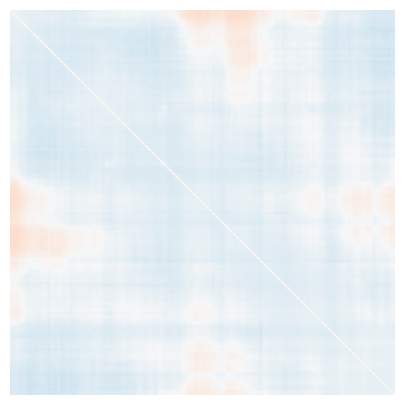

1


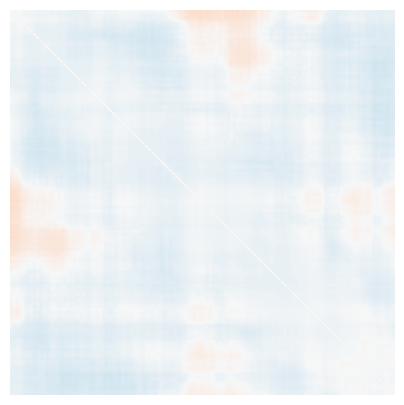

2


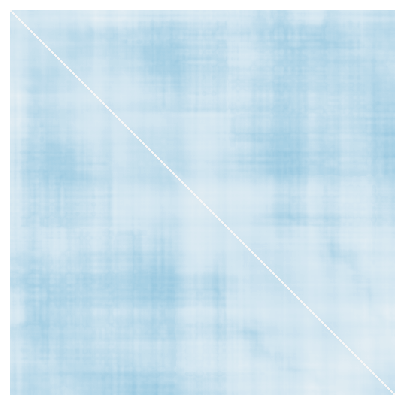

3


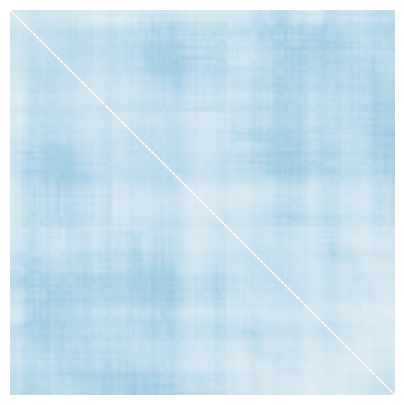

4


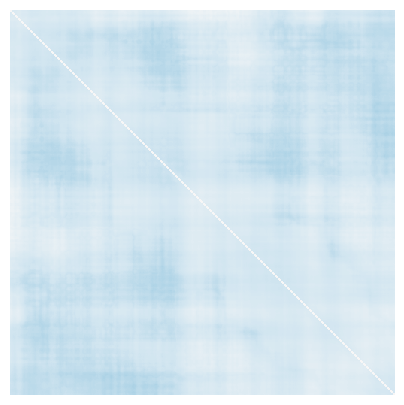

In [11]:
for i in range(5):
    mapa = hf_collected["refmap_h1_m0"][0,:,:,i]
    print(i)
    plot_map(mapa)

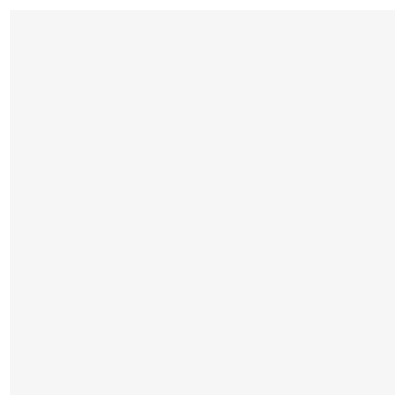

In [10]:
plot_map(hf_collected["map_h1_m0"][10,:,:,3])